In [479]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
FROM_SCRATCH = True

In [480]:
store = pd.read_csv('input/store.csv')
train = pd.read_csv('input/train.csv',parse_dates=[2])
test = pd.read_csv('input/test.csv',parse_dates=[3])
# fillna in store with 0 has better result than median()
# Aufbereiten der daten
store.fillna(0, inplace=True)
# fill missing values in test with 1
# Aufbereiten der Daten
test.fillna(value = 1, inplace = True)
# merge data with store
# Alles in eine Tabelle
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
# only use data of Sales>0 and Open is 1
train = train[(train.Open != 0)&(train.Sales >0)]

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


In [481]:
# gibt erste 5 Zeilen aus
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


Text(0.5, 1.0, 'Store 10 Sales Distribution')

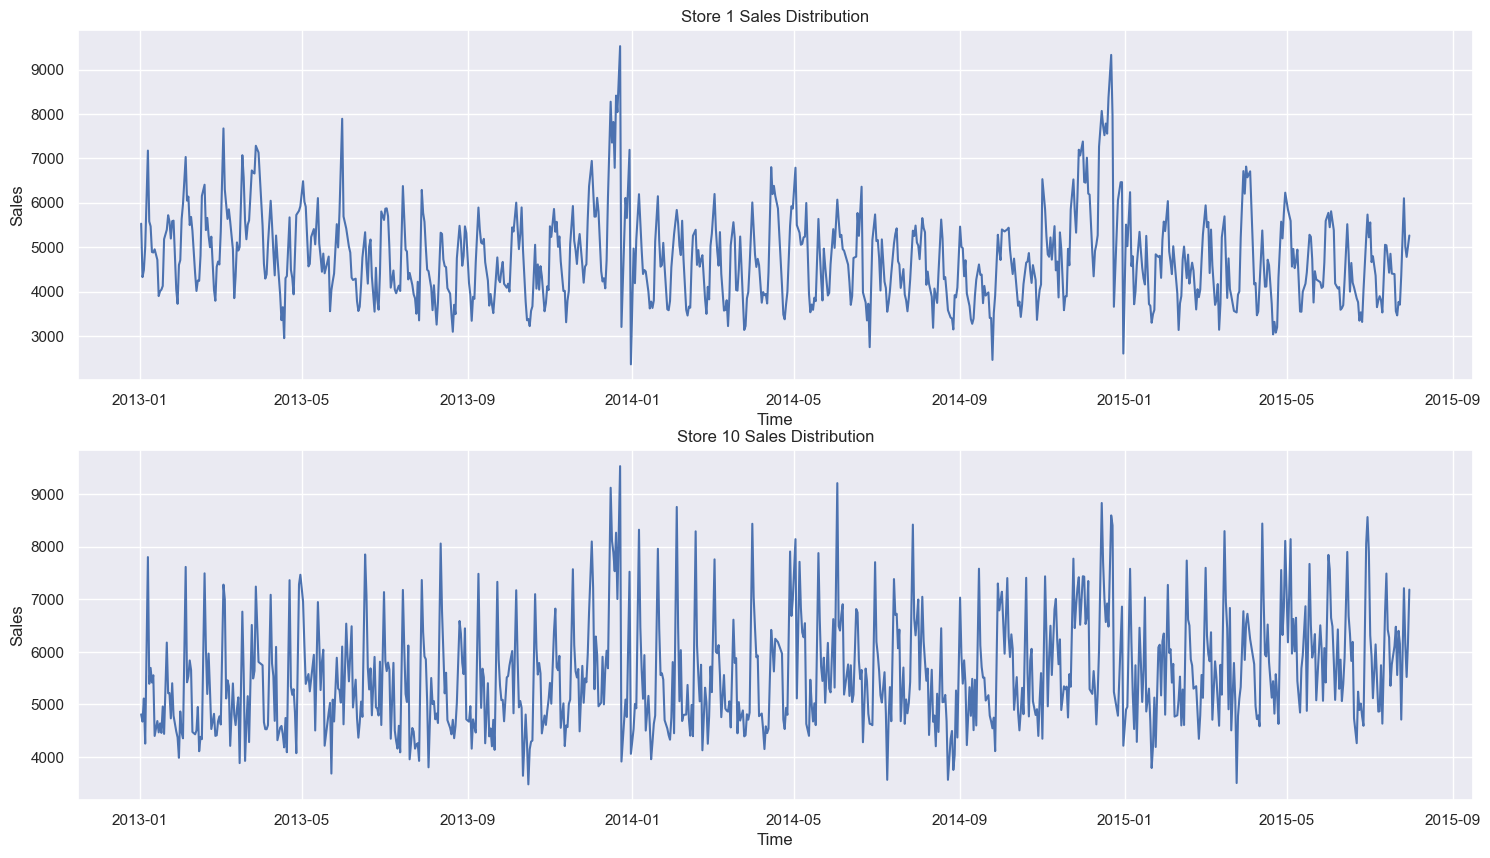

In [482]:
# zeichnet Verkuafsverteilung von Store 1 und 10 über den gesamten Zeitraum
import matplotlib.pyplot as plt
store_1 = train.loc[(train["Store"]==1)&(train['Sales']>0), ['Date',"Sales"]]
store_10 = train.loc[(train["Store"]==10)&(train['Sales']>0), ['Date',"Sales"]]
f = plt.figure(figsize=(18,10))
ax1 = f.add_subplot(211)
ax1.plot(store_1['Date'], store_1['Sales'], '-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Sales')
ax1.set_title('Store 1 Sales Distribution')

ax2 = f.add_subplot(212)
ax2.plot(store_10['Date'], store_10['Sales'], '-')
ax2.set_xlabel('Time')
ax2.set_ylabel('Sales')
ax2.set_title('Store 10 Sales Distribution')

Text(0.5, 1.0, 'Store Daily Open Countplot')

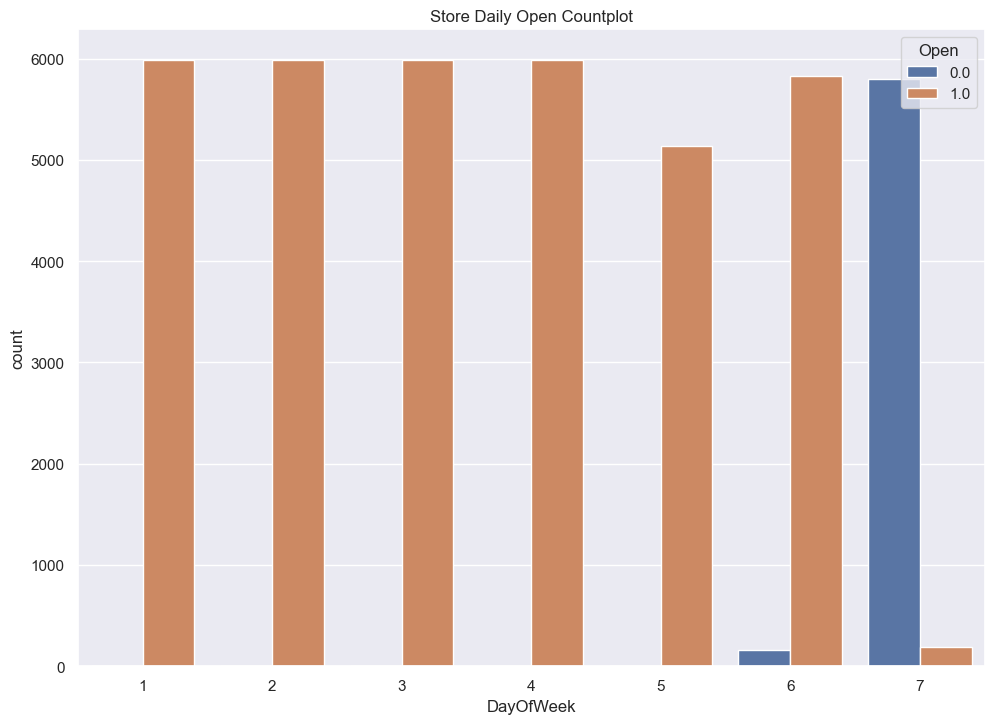

In [483]:
# zeigt Öffnungszeiten-Verteilung der Stores an allen Tagen an
import seaborn as sns
sns.countplot(x = 'DayOfWeek', hue = 'Open', data = test)
plt.title('Store Daily Open Countplot')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


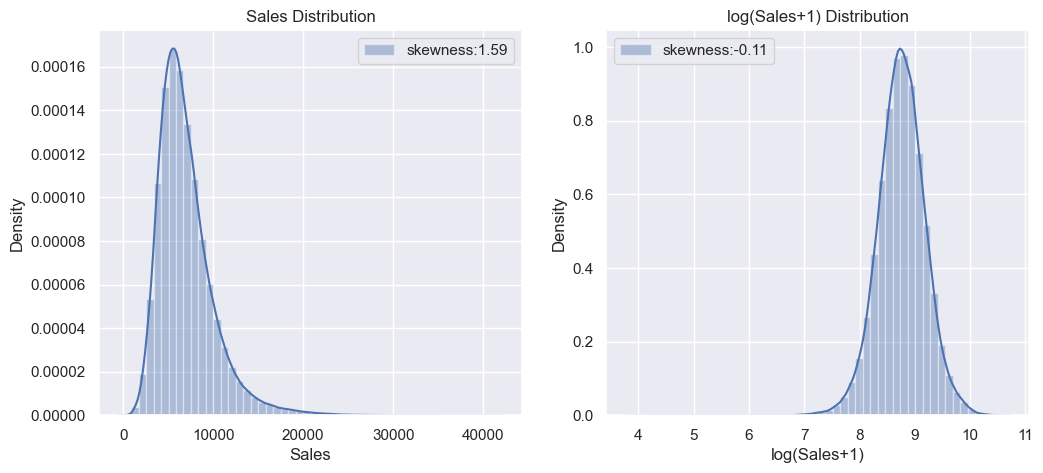

In [484]:
# Dichteverteilung der Verkaufszahlen. Einmal normal und einmal logarithmisch und normalisiert
import seaborn as sns
import matplotlib.pyplot as plt

# plotten der Verteilung der Verkäufe aller Stores der Trainingsdaten
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [485]:
nQ = 5
# neue Spalte 'Class' hinzugefügt
train['Class'] = 0
classes = np.arange(0,nQ+1)

#  Quantile für alle Tage
quantile = np.arange(1, nQ) / nQ
store_quan = np.arange(0, nQ+2)
store_quan[0] = -1
store_quan[1] = 1
# Quantile berechnet und max am Ende des Arrays gespeichert
for index, x in enumerate(quantile):
    store_quan[index+2] = train['Sales'].quantile(x)
store_quan[nQ+1] = train['Sales'].max()

"""
#  Quantil für verkaufsoffene Sonntage
store_df_day = train.loc[(train['DayOfWeek']== 7) & (train['Open'] == 1)]
quantile = np.arange(1, nQ) / nQ
store_quan_Sun = np.arange(0, nQ+2)
store_quan_Sun[0] = -1
store_quan_Sun[1] = 1
for index, x in enumerate(quantile):
    store_quan_Sun[index+2] = store_df_day['Sales'].quantile(x)
store_quan_Sun[nQ+1] = store_df_day['Sales'].max()

# Spezifische Quantile für jeden Tag und jeden Store
store_quan = np.zeros((train['Store'].max(), 7, nQ+2))
for Id in train['Store'].unique():
    store_df = train[train['Store'] == Id]
    for DayOfWeek in  store_df['DayOfWeek'].unique():
        if DayOfWeek != 7:
            store_df_day = store_df.loc[(store_df['DayOfWeek']== DayOfWeek) & (store_df['Open'] == 1)]
            quantile = np.arange(1, nQ) / nQ
            store_quan[Id-1][DayOfWeek-1][0] = -1
            store_quan[Id-1][DayOfWeek-1][1] = 1
            for index, x in enumerate(quantile):
                store_quan[Id-1][DayOfWeek-1][index+2] = store_df_day['Sales'].quantile(x)
            store_quan[Id-1][DayOfWeek-1][nQ+1] = store_df_day['Sales'].max()
        else:
            store_quan[Id-1][DayOfWeek-1] = store_quan_Sun
#"""

"\n#  Quantil für verkaufsoffene Sonntage\nstore_df_day = train.loc[(train['DayOfWeek']== 7) & (train['Open'] == 1)]\nquantile = np.arange(1, nQ) / nQ\nstore_quan_Sun = np.arange(0, nQ+2)\nstore_quan_Sun[0] = -1\nstore_quan_Sun[1] = 1\nfor index, x in enumerate(quantile):\n    store_quan_Sun[index+2] = store_df_day['Sales'].quantile(x)\nstore_quan_Sun[nQ+1] = store_df_day['Sales'].max()\n\n# Spezifische Quantile für jeden Tag und jeden Store\nstore_quan = np.zeros((train['Store'].max(), 7, nQ+2))\nfor Id in train['Store'].unique():\n    store_df = train[train['Store'] == Id]\n    for DayOfWeek in  store_df['DayOfWeek'].unique():\n        if DayOfWeek != 7:\n            store_df_day = store_df.loc[(store_df['DayOfWeek']== DayOfWeek) & (store_df['Open'] == 1)]\n            quantile = np.arange(1, nQ) / nQ\n            store_quan[Id-1][DayOfWeek-1][0] = -1\n            store_quan[Id-1][DayOfWeek-1][1] = 1\n            for index, x in enumerate(quantile):\n                store_quan[Id-1][

In [486]:
print(store_quan)

[   -1     1  4537  5758  7056  8958 41551]


In [487]:
# process train and test
# aufbereiten der daten, neue Spalten und manche werden entfernt
def process(data, isTest = False):
    # label encode some features
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    # buchstaben zu zahlen
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    # extract some features from date column
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)

    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    # schaut ob Monat ein Promomonat ist
    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
    # wenn ja dann hinzugefügt
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)

    # select the features we need
    features = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']

    # wenn kein Test dann hinzufügen von Sales
    if not isTest:
        features.append('Sales')

    data = data[features]
    return data

store_1 = train.loc[(train["Store"]==1) & (train['Date'] >= '2015-06-01')]
date_store_1 = store_1['Date'].tolist()
store_1 = process(store_1, isTest=False)
sales_store_1 = store_1['Sales']
del store_1['Sales']

store_2 = train.loc[(train["Store"]==2) & (train['Date'] >= '2015-06-01')]
date_store_2 = store_2['Date'].tolist()
store_2 = process(store_2, isTest=False)
sales_store_2 = store_2['Sales']
del store_2['Sales']

train = train.sort_values(['Date'],ascending = False)
train = process(train)
test = process(test,isTest = True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [488]:
# erste 5 zeilen von testdaten ausgeben
date_store_1

[Timestamp('2015-07-31 00:00:00'),
 Timestamp('2015-07-30 00:00:00'),
 Timestamp('2015-07-29 00:00:00'),
 Timestamp('2015-07-28 00:00:00'),
 Timestamp('2015-07-27 00:00:00'),
 Timestamp('2015-07-25 00:00:00'),
 Timestamp('2015-07-24 00:00:00'),
 Timestamp('2015-07-23 00:00:00'),
 Timestamp('2015-07-22 00:00:00'),
 Timestamp('2015-07-21 00:00:00'),
 Timestamp('2015-07-20 00:00:00'),
 Timestamp('2015-07-18 00:00:00'),
 Timestamp('2015-07-17 00:00:00'),
 Timestamp('2015-07-16 00:00:00'),
 Timestamp('2015-07-15 00:00:00'),
 Timestamp('2015-07-14 00:00:00'),
 Timestamp('2015-07-13 00:00:00'),
 Timestamp('2015-07-11 00:00:00'),
 Timestamp('2015-07-10 00:00:00'),
 Timestamp('2015-07-09 00:00:00'),
 Timestamp('2015-07-08 00:00:00'),
 Timestamp('2015-07-07 00:00:00'),
 Timestamp('2015-07-06 00:00:00'),
 Timestamp('2015-07-04 00:00:00'),
 Timestamp('2015-07-03 00:00:00'),
 Timestamp('2015-07-02 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2015-06-30 00:00:00'),
 Timestamp('2015-06-

In [489]:
# erste 5 zeilen von trainingsdaten ausgeben
train

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales
0,5,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,31,31,82.0,24187.75,0,5263
146142,5,1,0,1,4,3,5340.0,3.0,2012.0,1,13.0,2010.0,7,31,31,40.0,64.50,1,10735
143500,5,1,0,0,4,1,8530.0,3.0,2013.0,0,0.0,0.0,7,31,31,28.0,24187.75,0,9758
709530,5,1,0,1,1,1,18160.0,0.0,0.0,0,0.0,0.0,7,31,31,24187.0,24187.75,0,7834
144258,5,1,0,1,4,3,17110.0,11.0,2005.0,0,0.0,0.0,7,31,31,116.0,24187.75,0,7839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700661,2,0,1,1,2,2,840.0,0.0,0.0,1,48.0,2012.0,1,1,1,24157.0,0.25,1,5035
621467,2,0,1,1,2,1,150.0,9.0,2006.0,0,0.0,0.0,1,1,1,76.0,24156.25,0,3375
77677,2,0,1,1,2,1,1870.0,10.0,2011.0,0,0.0,0.0,1,1,1,15.0,24156.25,0,4220
512659,2,0,1,1,2,3,1210.0,0.0,0.0,0,0.0,0.0,1,1,1,24157.0,24156.25,0,8498


In [490]:
store_1

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,5,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,31,31,82.0,24187.75,0
1,4,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,30,31,82.0,24187.75,0
2,3,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,29,31,82.0,24187.75,0
3,2,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,28,31,82.0,24187.75,0
4,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,27,31,82.0,24187.75,0
6,6,0,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,25,30,82.0,24187.50,0
7,5,0,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,24,30,82.0,24187.50,0
8,4,0,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,23,30,82.0,24187.50,0
9,3,0,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,22,30,82.0,24187.50,0
10,2,0,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,7,21,30,82.0,24187.50,0


In [491]:
#Assortment und StoreType Plot

#plt.bar(train['Assortment'],train['Sales'])



In [492]:
# Liste mit den Features
featuresR  = ['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
# Features zu Arrays
train_data = train[featuresR].to_numpy()
test_data = test[featuresR].to_numpy()
labels_train = train[['Sales']].to_numpy()
labels_train = np.log1p(labels_train)

# Daten aufteilen in Test und Trainingsdaten, skalieren der Daten und Schätzer berechnen
X_trainR, X_testR, y_trainR, y_testR = train_test_split(train_data, labels_train, random_state=0, test_size= 2/31)
X_trainR, X_testR = X_trainR.astype('float32'), X_testR.astype('float32')
y_train_labR, y_test_labR = y_trainR[:, 0], y_testR[:, 0]
y_trainR, y_testR = y_trainR[:, 1:].astype('float32'), y_testR[:, 1:].astype('float32')
scalerR = StandardScaler()
scalerR.fit(X_trainR)

StandardScaler()

In [493]:
# bad_days = np.array([a for a, b in zip(X_trainR, y_trainR) if b[1] == 1])
# good_days = np.array([a for a, b in zip(X_trainR, y_trainR) if b[1] == 0])
xR = np.array([[5,1,0,1,3,3,45740.0,8.0,2008.0,1,0.0,0.0,2015,7,31,31,83.0,24187.75,0]])

In [494]:
# define eval metrics
# Mittleres Abweichungsquadrat
from sklearn.metrics import mean_squared_error
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
# expm1 ist umkehr von log1p
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)
def rmse(ytest, y):
    return np.sqrt(mean_squared_error(ytest, y))

In [495]:
y_train_xgb = y_train_labR
y_test_xgb = y_test_labR

In [496]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

def make_xgb_modelR():
    params = {"objective": "reg:linear", # for linear regression
              "booster" : "gbtree",   # use tree based models
              "eta": 0.03,   # learning rate
              "max_depth": 10,    # maximum depth of a tree
              "subsample": 0.9,    # Subsample ratio of the training instances
              "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
              "silent": 1,   # silent mode
              "seed": 10,   # Random number seed
              "gpu_id": 0,
              "tree_method": "gpu_hist",
              # "eval_metric": "rmse"
              }
    # anzahl trainingsrunden
    num_boost_round = 500

    dtrain = xgb.DMatrix(X_trainR, y_train_xgb)
    dtest = xgb.DMatrix(X_testR, y_test_xgb)
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    # train the xgboost model
    model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
      early_stopping_rounds= 10, feval=rmspe_xg, verbose_eval=True)
    y_predR = model.predict(xgb.DMatrix(X_testR))
    print(y_predR)
    print('accuracy_score:', rmse(y_predR, y_test_xgb))
    # print('f1_score:', f1_score(y_predR, y_test_xgb))

    return model

In [497]:
# Modell wird schon passend gespeichert @Bene :)
# Danke @Alex :D
import os.path

if FROM_SCRATCH or not os.path.isfile('modelXGBR.json'):
    modelXGBR = make_xgb_modelR()
    modelXGBR.save_model('modelXGBR.json')
else:
    modelXGBR = xgb.Booster()
    modelXGBR.load_model('modelXGBR.json')

`feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.


[08:53:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0082aa9edf5298699-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0082aa9edf5298699-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02110	train-rmspe:0.99981	eval-rmse:8.02201	eval-rmspe:0.99981
[1]	train-rmse:7.78096	train-rmspe:0.99971	eval-rmse:7.78188	eval-rmspe:0.99971
[2]	train-rmse:7.54807	train-rmspe:0.99959	eval-rmse:7.54900	eval-rmspe:0.99959
[3]	train-rmse:7.32212	train-rmspe:0.99944	eval-rmse:7.32308	eval-rmspe:0.99944
[4]	train-rmse:7.10298	train-rmspe:0.99927	eval-rmse:7.10399	eval-rmspe:0.99927
[5]	train-rmse:6.89038	train-rmspe:0.99905	eval-rmse:6.89142	eval-rmspe:0.99906
[6]	train-rmse:6.68420	train-rmspe:0.99880	eval-rmse:6.68529	eval-rmspe:0.99880
[7]	train-rms

In [498]:
# Berechnen von RMSE und RMSPE (root mean square percentage error)
#y_pred = np.rint(modelXGBR.predict(xgb.DMatrix(X_testR)))
y_pred = modelXGBR.predict(xgb.DMatrix(X_testR))
print(np.expm1(y_test_xgb))
print(y_pred)
error = rmse(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSE: {:.4f}'.format(error))
error = rmspe(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

[4323. 7333. 8198. ... 8153. 5619. 6210.]
[8.409349  8.935782  9.002992  ... 9.044499  8.557231  8.6518345]
RMSE: 966.9497
RMSPE: 0.1424


In [499]:
# Get XGBoost Feature Importance + Plot
"""
feature_importance = modelXGBR.get_score(importance_type= 'weight')
final_dict = dict(zip(featuresR,list(feature_importance.values())))
final_dict = dict(sorted(final_dict.items(), key=lambda x: x[1]))

plt.barh(*zip(*final_dict.items()))
"""

"\nfeature_importance = modelXGBR.get_score(importance_type= 'weight')\nfinal_dict = dict(zip(featuresR,list(feature_importance.values())))\nfinal_dict = dict(sorted(final_dict.items(), key=lambda x: x[1]))\n\nplt.barh(*zip(*final_dict.items()))\n"

In [500]:
"""
#Sequential Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_trainR, y_train_xgb)
importance = np.abs(ridge.coef_)
feature_names = np.array(featuresR)

#sfs_backward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="backward").fit(X_trainR,y_train_xgb)
sfs_forward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="forward").fit(X_trainR,y_train_xgb)
#print(
#    "Features selected by backward sequential selection: "
#    f"{feature_names[sfs_backward.get_support()]}"
#)
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
"""

'\n#Sequential Feature Selection\nfrom sklearn.feature_selection import SequentialFeatureSelector\nfrom sklearn.linear_model import RidgeCV\n\nridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_trainR, y_train_xgb)\nimportance = np.abs(ridge.coef_)\nfeature_names = np.array(featuresR)\n\n#sfs_backward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="backward").fit(X_trainR,y_train_xgb)\nsfs_forward = SequentialFeatureSelector(ridge, n_features_to_select=10,direction ="forward").fit(X_trainR,y_train_xgb)\n#print(\n#    "Features selected by backward sequential selection: "\n#    f"{feature_names[sfs_backward.get_support()]}"\n#)\nprint(\n    "Features selected by forward sequential selection: "\n    f"{feature_names[sfs_forward.get_support()]}"\n)\n'

In [501]:

# process train and test
# aufbereiten der daten, neue Spalten und manche werden entfernt
def process(data, isTest=False):

    # select the features we need
    features = ['DayOfWeek', 'Promo', 'Assortment', 'CompetitionDistance',
 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek',
 'Promo2SinceYear', 'Month', 'PromoOpen']
        #feature_names[sfs_forward.get_support()].tolist()

    # wenn kein Test dann hinzufügen von Sales
    if not isTest:
        features.append('Sales')

    data = data[features]
    return data


In [502]:
test.head()

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,4,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,9,17,38,84.0,24189.50,0
1,3,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,9,16,38,84.0,24189.50,0
2,2,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,9,15,38,84.0,24189.50,0
3,1,1,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,9,14,38,84.0,24189.50,0
4,7,0,0,0,3,1,1270.0,9.0,2008.0,0,0.0,0.0,9,13,37,84.0,24189.25,0


In [503]:

store_1 = process(store_1, isTest=True)
store_2 = process(store_2, isTest=True)
train = process(train)
test = process(test, isTest=True)
# erste 5 zeilen von testdaten ausgeben
test.head()
# erste 5 zeilen von trainingsdaten ausgeben
train.head()
# Liste mit den Features
#features = feature_names[sfs_forward.get_support()].tolist()
features = ['DayOfWeek', 'Promo', 'Assortment', 'CompetitionDistance',
 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek',
 'Promo2SinceYear', 'Month', 'PromoOpen']
# Features zu Arrays
train_data = train[features].to_numpy()
test_data = test[features].to_numpy()
store_1 = store_1[features].to_numpy()
store_2 = store_2[features].to_numpy()
sales_store_1 = sales_store_1.to_numpy()
sales_store_2 = sales_store_2.to_numpy()
labels_train = train[['Sales']].to_numpy()
labels_train = np.log1p(labels_train)

# Daten aufteilen in Test und Trainingsdaten, skalieren der Daten und Schätzer berechnen
X_train, X_test, y_train, y_test = train_test_split(train_data, labels_train, random_state=0)
X_train, X_test, store_1, store_2 = X_train.astype('float32'), X_test.astype('float32'),  store_1.astype('float32'), store_2.astype('float32')
y_train_xgb, y_test_xgb = y_train[:, 0], y_test[:, 0]
y_train, y_test = y_train[:, 1:].astype('float32'), y_test[:, 1:].astype('float32')
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [504]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


def make_xgb_model():
    params = {"objective": "reg:linear",  # for linear regression
              "booster": "gbtree",  # use tree based models
              "eta": 0.03,  # learning rate
              "max_depth": 10,  # maximum depth of a tree
              "subsample": 0.9,  # Subsample ratio of the training instances
              "colsample_bytree": 0.7,  # Subsample ratio of columns when constructing each tree
              "silent": 1,  # silent mode
              "seed": 10,  # Random number seed
              "gpu_id": 0,
              "tree_method": "gpu_hist",
              # "eval_metric": "rmse"
              }
    # anzahl trainingsrunden
    num_boost_round = 3000

    dtrain = xgb.DMatrix(X_train, y_train_xgb)
    dtest = xgb.DMatrix(X_test, y_test_xgb)
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]
    # train the xgboost model
    model = xgb.train(params, dtrain, num_boost_round, evals=watchlist,
                      early_stopping_rounds=10, feval=rmspe_xg, verbose_eval=True)
    y_pred = model.predict(xgb.DMatrix(X_test))
    print(y_pred)
    print('accuracy_score:', rmse(y_pred, y_test_xgb))
    # print('f1_score:', f1_score(y_predR, y_test_xgb))

    return model


# Modell wird schon passend gespeichert
import os.path

if FROM_SCRATCH or not os.path.isfile('modelXGBR.json'):
    modelXGB = make_xgb_model()
    modelXGB.save_model('modelXGB.json')
else:
    modelXGB = xgb.Booster()
    modelXGB.load_model('modelXGB.json')

[08:53:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0082aa9edf5298699-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0082aa9edf5298699-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:8.02068	train-rmspe:0.99981	eval-rmse:8.02252	eval-rmspe:0.99981
[1]	train-rmse:7.78054	train-rmspe:0.99971	eval-rmse:7.78238	eval-rmspe:0.99971


`feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.


[2]	train-rmse:7.54762	train-rmspe:0.99959	eval-rmse:7.54947	eval-rmspe:0.99959
[3]	train-rmse:7.32173	train-rmspe:0.99944	eval-rmse:7.32359	eval-rmspe:0.99944
[4]	train-rmse:7.10260	train-rmspe:0.99927	eval-rmse:7.10445	eval-rmspe:0.99927
[5]	train-rmse:6.89009	train-rmspe:0.99905	eval-rmse:6.89191	eval-rmspe:0.99905
[6]	train-rmse:6.68396	train-rmspe:0.99880	eval-rmse:6.68579	eval-rmspe:0.99880
[7]	train-rmse:6.48404	train-rmspe:0.99850	eval-rmse:6.48588	eval-rmspe:0.99850
[8]	train-rmse:6.29010	train-rmspe:0.99814	eval-rmse:6.29194	eval-rmspe:0.99814
[9]	train-rmse:6.10201	train-rmspe:0.99772	eval-rmse:6.10384	eval-rmspe:0.99772
[10]	train-rmse:5.91956	train-rmspe:0.99723	eval-rmse:5.92140	eval-rmspe:0.99724
[11]	train-rmse:5.74261	train-rmspe:0.99667	eval-rmse:5.74446	eval-rmspe:0.99667
[12]	train-rmse:5.57093	train-rmspe:0.99601	eval-rmse:5.57277	eval-rmspe:0.99602
[13]	train-rmse:5.40447	train-rmspe:0.99526	eval-rmse:5.40631	eval-rmspe:0.99527
[14]	train-rmse:5.24298	train-rmspe:

In [505]:
# Berechnen von RMSE und RMSPE (root mean square percentage error)
#y_pred = np.rint(modelXGBR.predict(xgb.DMatrix(X_testR)))
y_pred = modelXGB.predict(xgb.DMatrix(X_test))
print(np.expm1(y_test_xgb))
print(y_pred)
error = rmse(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSE: {:.4f}'.format(error))
error = rmspe(np.expm1(y_test_xgb), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

[4323. 7333. 8198. ... 4470. 5615. 1269.]
[8.432276  8.917568  8.981313  ... 8.337467  8.537442  7.3672338]
RMSE: 920.0909
RMSPE: 0.1582


In [506]:

category_map = { 0: ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 1:["No", "Yes"],
                 2: [ "?", "Basic", "Extra", "Extended"], 8:["None","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]}

#features = ['DayOfWeek', 'Promo', 'Assortment', 'CompetitionDistance',
# 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek',
# 'Promo2SinceYear', 'Month', 'PromoOpen']


In [507]:
"""
# Umwandlung von kontinuierlichen in kategorische Daten
def bin(input_array, data):
    output_array = np.zeros(input_array.shape)
    for i in range(len(input_array)):
        Id = data[i][0]
        Day = data[i][1]
        print(Day)
        print(Id)
        print(input_array[i])
        print(store_quan[np.rint(Id)][np.rint(Day)])
        output_array[i] = np.searchsorted(store_quan[np.rint(Id)][np.rint(Day)], input_array[i])
    return output_array
#"""

'\n# Umwandlung von kontinuierlichen in kategorische Daten\ndef bin(input_array, data):\n    output_array = np.zeros(input_array.shape)\n    for i in range(len(input_array)):\n        Id = data[i][0]\n        Day = data[i][1]\n        print(Day)\n        print(Id)\n        print(input_array[i])\n        print(store_quan[np.rint(Id)][np.rint(Day)])\n        output_array[i] = np.searchsorted(store_quan[np.rint(Id)][np.rint(Day)], input_array[i])\n    return output_array\n#'

In [508]:
def bin(input_array):
    output_array = np.zeros(input_array.shape)
    for i in range(len(input_array)):
        output_array[i] = np.searchsorted(store_quan, input_array[i])
    return output_array

In [509]:
"""
from alibi.explainers import AnchorTabular
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
predict_xgb = lambda x: bin(np.expm1(modelXGBR.predict(xgb.DMatrix(x))))
explainerXGB = AnchorTabular(predict_xgb, featuresR, categorical_names=category_map)
explainerXGB.fit(X_trainR, disc_perc=(25, 50, 75))
resultXGB = explainerXGB.explain(xR, threshold=0.9)
"""

'\nfrom alibi.explainers import AnchorTabular\nos.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"\nos.environ["CUDA_VISIBLE_DEVICES"]="0"\npredict_xgb = lambda x: bin(np.expm1(modelXGBR.predict(xgb.DMatrix(x))))\nexplainerXGB = AnchorTabular(predict_xgb, featuresR, categorical_names=category_map)\nexplainerXGB.fit(X_trainR, disc_perc=(25, 50, 75))\nresultXGB = explainerXGB.explain(xR, threshold=0.9)\n'

In [510]:
from alibi.explainers import AnchorTabular
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
predict_xgb = lambda x: bin(np.expm1(modelXGB.predict(xgb.DMatrix(x))))
explainerXGB = AnchorTabular(predict_xgb, features, categorical_names= category_map)
explainerXGB.fit(X_train, disc_perc=(14, 28, 42, 56, 70, 84))
# resultXGB = explainerXGB.explain(xR, threshold=0.9)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (14, 28, 42, 56, 70, 84)},
  'version': '0.8.0'}
)

In [511]:
"""
print('Anchor =', resultXGB.data['anchor'])
print('Precision = ', resultXGB.data['precision'])
print('Coverage = ', resultXGB.data['coverage'])
"""

"\nprint('Anchor =', resultXGB.data['anchor'])\nprint('Precision = ', resultXGB.data['precision'])\nprint('Coverage = ', resultXGB.data['coverage'])\n"

In [512]:
idx = 11
print(explainerXGB.predictor(X_test[idx].reshape(1, -1))[0])
explanation = explainerXGB.explain(X_test[idx], threshold=0.8)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

4.0


Could not find an anchor satisfying the 0.8 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Anchor: 1700.00 < CompetitionDistance <= 5290.00 AND Assortment = Extended AND 10.50 < PromoOpen <= 29.00 AND 2011.00 < Promo2SinceYear <= 2013.00 AND Promo = Yes AND CompetitionOpenSinceYear <= 0.00 AND CompetitionOpenSinceMonth <= 0.00 AND Month = Apr AND 0.00 < Promo2SinceWeek <= 14.00 AND DayOfWeek = Tuesday
Precision: 0.72
Coverage: 0.00


In [513]:
"""
def filter_array(array):
  filtered = []
  substrings = ['Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
  for element in array:
    for substring in substrings:
      if substring in element:
        filtered.append(element)
        break
  return filtered
  """

"\ndef filter_array(array):\n  filtered = []\n  substrings = ['Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']\n  for element in array:\n    for substring in substrings:\n      if substring in element:\n        filtered.append(element)\n        break\n  return filtered\n  "

In [514]:
#new = filter_array(explanation.anchor)
#print(new)

In [515]:
explanation

Explanation(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': (14, 28, 42, 56, 70, 84),
              'threshold': 0.8,
              'delta': 0.1,
              'tau': 0.15,
              'batch_size': 100,
              'coverage_samples': 10000,
              'beam_size': 1,
              'stop_on_first': False,
              'max_anchor_size': None,
              'min_samples_start': 100,
              'n_covered_ex': 10,
              'binary_cache_size': 10000,
              'cache_margin': 1000,
              'verbose': False,
              'verbose_every': 1,
              'kwargs': {}}
            ,
  'version': '0.8.0'}
, data={
  'anchor': ['1700.00 < CompetitionDistance <= 5290.00', 'Assortment = Extended', '10.50 < PromoOpen <= 29.00', '2011.00 < Promo2SinceYear <= 2013.00', 'Promo = Yes', 'CompetitionOpenSinceYear <= 0.00', 'CompetitionOpenSinceMonth <= 0.00', 'Month 

In [516]:
#Liste mit Erklärungen (Parameter müssen noch rein)
exps = []
for i in range(0,len(store_1)):
    print(i)
    exps.append(explainerXGB.explain(store_1[i], threshold=0.75, beam_size=2))

0


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


1


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


2


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


3


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


4


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


5
6


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


7


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


8


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


9


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


10


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


11
12


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


13


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


14


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


15


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


16


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


17
18


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


19


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


20


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


21


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


22


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


23
24


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


25


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


26


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


27


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


28


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


29


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


30


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


31


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


32


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


33


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


34


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


35


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


36


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


37


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


38


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


39


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


40


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


41


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


42


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


43


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


44


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


45


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


46


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


47


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


48


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


49


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


50


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


51


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


In [517]:
#Tests
a = []
a.append(exps[0].anchor)
print(a[0])
test_1 = np.expm1(modelXGB.predict(xgb.DMatrix(store_1)))
print(len(exps))
date_store_1

['870.00 < CompetitionDistance <= 1700.00', '6.00 < CompetitionOpenSinceMonth <= 9.00', 'CompetitionOpenSinceYear <= 2010.00', 'Assortment = Basic', 'DayOfWeek = Saturday', 'Promo2SinceWeek <= 0.00', 'Promo = Yes', 'Month = Jul', 'Promo2SinceYear <= 2013.00']
52


[Timestamp('2015-07-31 00:00:00'),
 Timestamp('2015-07-30 00:00:00'),
 Timestamp('2015-07-29 00:00:00'),
 Timestamp('2015-07-28 00:00:00'),
 Timestamp('2015-07-27 00:00:00'),
 Timestamp('2015-07-25 00:00:00'),
 Timestamp('2015-07-24 00:00:00'),
 Timestamp('2015-07-23 00:00:00'),
 Timestamp('2015-07-22 00:00:00'),
 Timestamp('2015-07-21 00:00:00'),
 Timestamp('2015-07-20 00:00:00'),
 Timestamp('2015-07-18 00:00:00'),
 Timestamp('2015-07-17 00:00:00'),
 Timestamp('2015-07-16 00:00:00'),
 Timestamp('2015-07-15 00:00:00'),
 Timestamp('2015-07-14 00:00:00'),
 Timestamp('2015-07-13 00:00:00'),
 Timestamp('2015-07-11 00:00:00'),
 Timestamp('2015-07-10 00:00:00'),
 Timestamp('2015-07-09 00:00:00'),
 Timestamp('2015-07-08 00:00:00'),
 Timestamp('2015-07-07 00:00:00'),
 Timestamp('2015-07-06 00:00:00'),
 Timestamp('2015-07-04 00:00:00'),
 Timestamp('2015-07-03 00:00:00'),
 Timestamp('2015-07-02 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2015-06-30 00:00:00'),
 Timestamp('2015-06-

In [518]:
#In csv speichern (überschreibt immer, wenn man für anderen Store will Dateiname ändern und oben Storenummer ändern)
import pandas as pd
anchors = []
precisions = []
bins = []
predsales_store_1 = np.expm1(modelXGB.predict(xgb.DMatrix(store_1)))
predsales_store_1_list = []
sales_store_1_list = []
date_store_1_list = []

for i in range(0,len(exps)):
    anchors.append(exps[i].anchor)
    precisions.append(exps[i].precision)
    bins.append(explainerXGB.predictor(store_1[i].reshape(1, -1))[0])
    predsales_store_1_list.append(predsales_store_1[i])
    sales_store_1_list.append(sales_store_1[i])
    date_store_1_list.append(date_store_1[i])

dict = {'Anchors': anchors, 'Precisions': precisions, 'Classes': bins, 'Predicted Sales': predsales_store_1_list, 'Dates': date_store_1_list, 'ESales': sales_store_1_list}
df = pd.DataFrame(dict)
df.to_csv('explanations_Store3.csv')

Store 2.0

In [519]:
exps = []
for i in range(0,len(store_2)):
    print(i)
    exps.append(explainerXGB.explain(store_2[i], threshold=0.75, beam_size=2))

0
1


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


17
18
19
20
21
22
23
24
25
26
27


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Could not find an anchor satisfying the 0.75 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


50
51
52


In [520]:
a = [exps[0].anchor]
print(a[0])
test_1 = np.expm1(modelXGB.predict(xgb.DMatrix(store_2)))
print(len(exps))
date_store_2

['2005.00 < CompetitionOpenSinceYear <= 2007.00', 'Assortment = Basic', 'CompetitionOpenSinceMonth > 10.00', 'DayOfWeek = Saturday', '330.00 < CompetitionDistance <= 870.00', 'Month = Jul', 'PromoOpen <= 24160.25', 'Promo = Yes', 'Promo2SinceYear <= 2013.00']
53


[Timestamp('2015-07-31 00:00:00'),
 Timestamp('2015-07-30 00:00:00'),
 Timestamp('2015-07-29 00:00:00'),
 Timestamp('2015-07-28 00:00:00'),
 Timestamp('2015-07-27 00:00:00'),
 Timestamp('2015-07-25 00:00:00'),
 Timestamp('2015-07-24 00:00:00'),
 Timestamp('2015-07-23 00:00:00'),
 Timestamp('2015-07-22 00:00:00'),
 Timestamp('2015-07-21 00:00:00'),
 Timestamp('2015-07-20 00:00:00'),
 Timestamp('2015-07-18 00:00:00'),
 Timestamp('2015-07-17 00:00:00'),
 Timestamp('2015-07-16 00:00:00'),
 Timestamp('2015-07-15 00:00:00'),
 Timestamp('2015-07-14 00:00:00'),
 Timestamp('2015-07-13 00:00:00'),
 Timestamp('2015-07-11 00:00:00'),
 Timestamp('2015-07-10 00:00:00'),
 Timestamp('2015-07-09 00:00:00'),
 Timestamp('2015-07-08 00:00:00'),
 Timestamp('2015-07-07 00:00:00'),
 Timestamp('2015-07-06 00:00:00'),
 Timestamp('2015-07-04 00:00:00'),
 Timestamp('2015-07-03 00:00:00'),
 Timestamp('2015-07-02 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2015-06-30 00:00:00'),
 Timestamp('2015-06-

In [521]:
import pandas as pd
anchors = []
precisions = []
bins = []
predsales_store_2 = np.expm1(modelXGB.predict(xgb.DMatrix(store_2)))
predsales_store_2_list = []
sales_store_2_list = []
date_store_2_list = []

for i in range(0,len(exps)):
    anchors.append(exps[i].anchor)
    precisions.append(exps[i].precision)
    bins.append(explainerXGB.predictor(store_2[i].reshape(1, -1))[0])
    predsales_store_2_list.append(predsales_store_2[i])
    sales_store_2_list.append(sales_store_2[i])
    date_store_2_list.append(date_store_2[i])

dict = {'Anchors': anchors, 'Precisions': precisions, 'Classes': bins, 'Predicted Sales': predsales_store_2_list, 'Dates': date_store_2_list, 'ESales': sales_store_2_list}
df = pd.DataFrame(dict)
df.to_csv('explanations_Store4.csv')